---
comments: true
layout: post
type: hacks
title: ML CPT
courses: { compsci: {week: 13} }
---

# Our ML Project: Titanic + CPT

In this blog, I  will show my understanding  of my  code for the titanic machine learning model, as well as our own personalized CPT machine learning project.

# Titanic ML:

For the titanic project, we worked on trainig the model with the titanic dataset. Using an API, we recieved data from the frontend, made the prediction, and sent the prediction back to the frontend to display. This is the old version of my code, where I didn't have init function so it ran each time I did python main.py and it was more cluttered this way. I also put this in jokes.py because when I created a new titanic.py for api and model, it didn't work in POSTMAN and I got a 404 error because I forgot the add a resource for the new API in main.py. I saw the updated teacher's code too, we did the same thing but there were small differences, like different names for functions, etc.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np


class TitanicPredictor:   # Define a Class
   def __init__(self):
       self.data = None
       self.encoder = None
       self.model_dt = None
       self.model_logreg = None
       self.X_test = None
       self.y_test = None
      
   def load_data(self):   # Load data for titanic
       self.data = sns.load_dataset('titanic')
      
   def preprocess_data(self): # Drop columns that don't matter
       if self.data is None:
           raise ValueError("Data not loaded. Call load_data() first.")
      
       self.data.drop(['alive', 'who', 'adult_male', 'class', 'embark_town', 'deck'], axis=1, inplace=True)
       self.data.dropna(inplace=True)
       
       # Convert sex/alone to binary
       self.data['sex'] = self.data['sex'].apply(lambda x: 1 if x == 'male' else 0)
       self.data['alone'] = self.data['alone'].apply(lambda x: 1 if x == True else 0)
      
       self.encoder = OneHotEncoder(handle_unknown='ignore')
       self.encoder.fit(self.data[['embarked']])
       onehot = self.encoder.transform(self.data[['embarked']]).toarray()
       cols = ['embarked_' + val for val in self.encoder.categories_[0]]
       self.data[cols] = pd.DataFrame(onehot)
       self.data.drop(['embarked'], axis=1, inplace=True)
       self.data.dropna(inplace=True)
       #It performs one-hot encoding on the 'embarked' column, replacing it with binary columns representing different embarkation points.
       #It drops the original 'embarked' column.
       # It drops any remaining rows with missing values after the preprocessing steps.
      
   def train_models(self):
       X = self.data.drop('survived', axis=1) # Drops survived model  for ex axis
       y = self.data['survived'] # Has survived
       #
       
       X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)
      
       self.model_dt = DecisionTreeClassifier()
       self.model_dt.fit(X_train, y_train)
      
       self.model_logreg = LogisticRegression()
       self.model_logreg.fit(X_train, y_train)
      # Organize datat into DecisionTreeClassifier() and LogisticRegression()
      
   def evaluate_models(self): # Evaluate models
       if self.model_dt is None or self.model_logreg is None:
           raise ValueError("Models not trained. Call train_models() first.")
      
       y_pred_dt = self.model_dt.predict(self.X_test)
       accuracy_dt = accuracy_score(self.y_test, y_pred_dt)
       print('DecisionTreeClassifier Accuracy: {:.2%}'.format(accuracy_dt)) 
      
       y_pred_logreg = self.model_logreg.predict(self.X_test)
       accuracy_logreg = accuracy_score(self.y_test, y_pred_logreg)
       print('LogisticRegression Accuracy: {:.2%}'.format(accuracy_logreg)) 
  
   def predict_survival_probability(self, new_passenger):
       if self.model_logreg is None:
           raise ValueError("Models not trained. Call train_models() first.")
      
       new_passenger['sex'] = new_passenger['sex'].apply(lambda x: 1 if x == 'male' else 0)
       new_passenger['alone'] = new_passenger['alone'].apply(lambda x: 1 if x == True else 0)
      
       onehot = self.encoder.transform(new_passenger[['embarked']]).toarray()
       cols = ['embarked_' + val for val in self.encoder.categories_[0]]
       new_passenger[cols] = pd.DataFrame(onehot, index=new_passenger.index)
       new_passenger.drop(['embarked'], axis=1, inplace=True)
       new_passenger.drop(['name'], axis=1, inplace=True)
      
       dead_proba, alive_proba = np.squeeze(self.model_logreg.predict_proba(new_passenger))
       print('Death probability: {:.2%}'.format(dead_proba)) 
       print('Survival probability: {:.2%}'.format(alive_proba)) 
       return dead_proba, alive_proba


# Usage
titanic_predictor = TitanicPredictor()
titanic_predictor.load_data()
titanic_predictor.preprocess_data()
titanic_predictor.train_models()
titanic_predictor.evaluate_models()


# Define a new passenger
passenger = pd.DataFrame({
   'name': ['John Mortensen'],
   'pclass': [2],
   'sex': ['male'],
   'age': [64],
   'sibsp': [1],
   'parch': [1],
   'fare': [16.00],
   'embarked': ['S'],
   'alone': [False]
})


titanic_predictor.predict_survival_probability(passenger)


DecisionTreeClassifier Accuracy: 74.71%
LogisticRegression Accuracy: 78.82%
Death probability: 90.60%
Survival probability: 9.40%


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9059738025923634, 0.09402619740763668)

# New Code
This is the updated code that I used after my live review by making the code more efficient. I also found out why I kept getting a 404 page for main.py because I forgot to add a resource of the API for titanic.py. Here is the new code with the updated changes for main.py first and then titanic.py

# main.py

In [2]:
import threading

# import "packages" from flask
from flask import render_template,request  # import render_template from "public" flask libraries
from flask.cli import AppGroup


# import "packages" from "this" project
from __init__ import app, db, cors  # Definitions initialization


# setup APIs
from api.covid import covid_api # Blueprint import api definition
from api.titanic import titanic_api # Blueprint import api definition
from api.user import user_api # Blueprint import api definition
from api.player import player_api
from api.depression import predict_api
# database migrations
from model.users import initUsers
from model.players import initPlayers
from model.titanic import initTitanic

# setup App pages
from projects.projects import app_projects # Blueprint directory import projects definition


# Initialize the SQLAlchemy object to work with the Flask app instance
db.init_app(app)

# register URIs
app.register_blueprint(titanic_api) # register api routes
app.register_blueprint(covid_api) # register api routes
app.register_blueprint(user_api) # register api routes
app.register_blueprint(player_api)
app.register_blueprint(predict_api)
app.register_blueprint(app_projects) # register app pages

@app.errorhandler(404)  # catch for URL not found
def page_not_found(e):
    # note that we set the 404 status explicitly
    return render_template('404.html'), 404

@app.route('/')  # connects default URL to index() function
def index():
    return render_template("index.html")

@app.route('/table/')  # connects /stub/ URL to stub() function
def table():
    return render_template("table.html")

@app.before_request
def before_request():
    # Check if the request came from a specific origin
    allowed_origin = request.headers.get('Origin')
    if allowed_origin in ['http://localhost:4100', 'http://127.0.0.1:4100', 'https://Lin-cT.github.io']:
        cors._origins = allowed_origin

# Create an AppGroup for custom commands
custom_cli = AppGroup('custom', help='Custom commands')

# Define a command to generate data
@custom_cli.command('generate_data')
def generate_data():
    initUsers()
    initPlayers()
    initTitanic()

# Register the custom command group with the Flask application
app.cli.add_command(custom_cli)
        
# this runs the application on the development server
if __name__ == "__main__":
    # change name for testing
    app.run(debug=True, host="0.0.0.0", port="8086")


ModuleNotFoundError: No module named '__init__'

# titanic.py (model)

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np


#Rest of code is unchanged 

# Usage
titanic_predictor = TitanicPredictor() #global varible


def initTitanic(): #define function/run processes inside it!
    titanic_predictor.load_data()
    titanic_predictor.preprocess_data()
    titanic_predictor.train_models()
    titanic_predictor.evaluate_models()
# Define a new passenger
    passenger = pd.DataFrame({ # pass in datafram
    'name': ['John Mortensen'],
    'pclass': [2],
    'sex': ['male'],
    'age': [64],
    'sibsp': [1],
    'parch': [1],
    'fare': [16.00],
    'embarked': ['S'],
    'alone': [False]
    })
    return titanic_predictor.predict_survival_probability(passenger) #return





### Titanic Model: 

Data Loading and Preprocessing:
The model begins by loading the Titanic dataset using Seaborn's load_dataset() function.
It then preprocesses the data by dropping irrelevant columns ('alive', 'who', 'adult_male', 'class', 'embark_town', 'deck') and handling missing values.
Categorical variables like 'sex' and 'alone' are converted into numerical format.

One-Hot Encoding:
The model uses one-hot encoding to convert the categorical variable 'embarked' into binary vectors. Sex, for example, is coded into 1/0s. 

Model Training:
After preprocessing, the data is split into features (X) and the target variable (y), followed by splitting into training and testing sets.
Two models are trained: a Decision Tree Classifier (model_dt) and a Logistic Regression model (model_logreg).

Model Evaluation:
The trained models are evaluated using accuracy scores on the test data.

Prediction:
The model provides a method predict_survival_probability() to predict the survival probability of a new passenger.
The new passenger's data is preprocessed similarly to the training data.
The survival probability is predicted using the trained Logistic Regression model.

Usage Example:
An instance of the TitanicPredictor class is created.
Data is loaded, preprocessed, models are trained, and then evaluated.
A new passenger's data is defined, and the predict_survival_probability() method is called to estimate their survival probability.

In [ ]:
from flask import Blueprint, jsonify, request  # jsonify creates an endpoint response object
from flask_restful import Api, Resource # used for REST API building

from model.jokes import *

joke_api = Blueprint('joke_api', __name__,
                   url_prefix='/api/jokes')

# API generator https://flask-restful.readthedocs.io/en/latest/api.html#id1
api = Api(joke_api)

class TitanicAPI(Resource):
    def post(self):
            # Get passenger data from the API request
            data = request.get_json()  # get the data as JSON
            data['alone'] = str(data['alone']).lower()
            converted_dict = {key: [value] for key, value in data.items()}
            pass_in = pd.DataFrame(converted_dict)  # create DataFrame from JSON
            titanic_predictor = TitanicPredictor()
            titanic_predictor.load_data()
            titanic_predictor.preprocess_data()
            titanic_predictor.train_models()
            titanic_predictor.evaluate_models()
            dead_proba, alive_proba = titanic_predictor.predict_survival_probability(pass_in)
            response = {
                'dead_proba': dead_proba,  # Example probabilities, replace with actual values
                'alive_proba': alive_proba
            }
            return jsonify(response)


# Add resource to the API
api.add_resource(TitanicAPI, '/create')

### Titanic API:

The TitanicAPI class is a Flask-Restful Resource representing an endpoint of the API. It handles POST requests to the /api/jokes/create endpoint.
In the post method, it gets  passenger data from the JSON request using request.get_json().
The passenger data is processed and formatted into  a Python dictionary, and then passed to the TitanicPredictor class (assumed to be defined elsewhere) for prediction. After predicting survival probabilities, a JSON response containing the probabilities is created. One mistake I made previously was only jsonifying the data and not putting in a key value pair (hashmap!) Here I convert the data I fetched into Python dictionary and convert the data I returned into JSON!

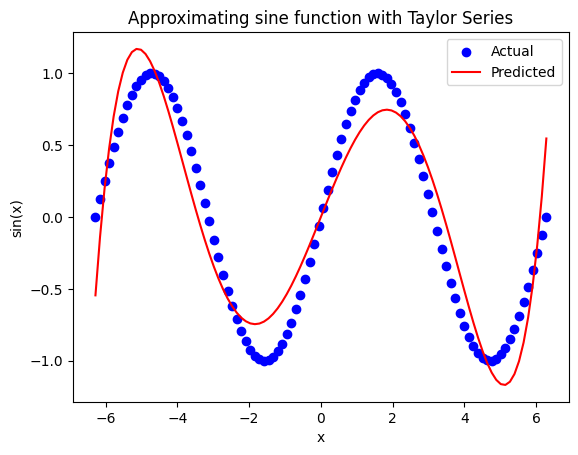

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Generate data
x = np.linspace(-2*np.pi, 2*np.pi, 100).reshape(-1, 1)
y = np.sin(x)

# Feature engineering: Use polynomial features up to degree 5
poly_features = PolynomialFeatures(degree=5)
X_poly = poly_features.fit_transform(x)

# Model training
model = LinearRegression()
model.fit(X_poly, y)

# Predict
y_pred = model.predict(X_poly)

# Plot results
plt.scatter(x, y, color='blue', label='Actual')
plt.plot(x, y_pred, color='red', label='Predicted')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.title('Approximating sine function with Taylor Series Order 5')
plt.show()
